In [1]:
pip install pybaseball

Note: you may need to restart the kernel to use updated packages.


In [96]:
pip install requests pandas

In [33]:
!pip install xgboost 

  Using cached xgboost-3.0.1-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/150.0 MB 4.8 MB/s eta 0:00:32
    --------------------------------------- 2.6/150.0 MB 5.6 MB/s eta 0:00:27
    --------------------------------------- 3.7/150.0 MB 5.3 MB/s eta 0:00:28
   - -------------------------------------- 5.0/150.0 MB 5.5 MB/s eta 0:00:27
   - -------------------------------------- 6.3/150.0 MB 5.8 MB/s eta 0:00:25
   -- ------------------------------------- 7.6/150.0 MB 5.8 MB/s eta 0:00:25
   -- ------------------------------------- 8.9/150.0 MB 5.9 MB/s eta 0:00:24
   -- ------------------------------------- 10.2/150.0 MB 6.0 MB/s eta 0:00:24
   --- ------------------------------------ 11.3/150.0 MB 5.9 MB/s eta 0:00:24
   --- ------------------------------------ 12.6/150.0 MB 6.0 MB/s eta 0:00:24
   --

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\justi\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\justi\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\justi\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\justi\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\justi\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\justi\anaconda3\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^

In [3]:
from pybaseball import statcast, playerid_lookup, playerid_reverse_lookup, team_ids, statcast_batter
import pandas as pd
import requests
import statsapi
import json
import datetime

In [25]:
pd.set_option('display.max_columns', None)

In [7]:
# Calculate the date range
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=40)
 
# Format dates as MM/DD/YYYY
start_date_str = start_date.strftime('%m/%d/%Y')
end_date_str = end_date.strftime('%m/%d/%Y')
 
def get_batters_hrr_for_game(gamePk, team_type='away'):
    # Fetch the boxscore data
    boxscore = statsapi.boxscore_data(gamePk, timecode=None)
 
    # Check if the team_type is valid
    if team_type not in ['home', 'away']:
        raise ValueError("Invalid team_type. Use 'home' or 'away'.")
 
    # Initialize an empty list to store parsed data
    parsed_data = []
 
    # Get the batting order for the specified team
    batting_order = boxscore[team_type]['battingOrder']
 
    # Iterate over each player in the specified team
    for player_id, player_data in boxscore[team_type]['players'].items():
        # Remove the first two characters from player_id and convert to integer
        player_id_real = int(player_id[2:])
        # Check if 'batting' exists and has the necessary keys
        if player_data['stats']['batting']:
            batting_stats = player_data['stats']['batting']
            hits = batting_stats['hits']
            runs = batting_stats['runs']
            rbi = batting_stats['rbi']
        else:
            hits = runs = rbi = 0
 
        # Determine the batting position
        if 'battingOrder' in player_data and player_data['battingOrder']:
            batting_position = player_data['battingOrder']
        else:
            batting_position = None  # If player_id is not found in battingOrder
 
        # Create a dictionary with the parsed data
        parsed_entry = {
            'full_name': player_data['person']['fullName'],
            'hrr': hits + runs + rbi,
            'batting_position': batting_position
        }
 
        # Append the parsed entry to the list
        if batting_position is not None:
            parsed_data.append(parsed_entry)
    return parsed_data
    # # Filter for the top 3 batters (batting positions 1, 2, and 3)
    # top_batters = [player for player in parsed_data if int(player['batting_position']) in [100, 200, 300]]
    # if len(top_batters) == 3:
    #     # Check if all top 3 batters have more than 1.5 HRR or all have less than 1.5 HRR
    #     all_above_1_5 = all(player['hrr'] > 1.5 for player in top_batters)
    #     all_below_1_5 = all(player['hrr'] < 1.5 for player in top_batters)
 
    #     if all_below_1_5:
    #         return True
 
    # return False
 
 
# # Fetch the teams with their IDs and names
teams = statsapi.get('teams', {'sportIds': 1, 'activeStatus': 'Yes', 'fields': 'teams,name,id'})['teams']
 
combined_df = pd.DataFrame()
 
# # Loop through each team and fetch their schedule for the specified date range
for team in teams:
    team_id = team['id']
    team_name = team['name']
 
    # Fetch the schedule for the current team
    schedule = statsapi.schedule(team=team_id, start_date=start_date_str, end_date=end_date_str)
    sync_count = 0
    unsync_count = 0
 
 
    # Filter the schedule to include only game_id and game_date
    for game in schedule:
        for value in ['home','away']:
            game_data = get_batters_hrr_for_game(game['game_id'], value)
            game_df = pd.DataFrame(game_data)
            game_team_id = value + '_id'
            game_team_name = value + '_name'
            game_df['team_id'] = game[game_team_id]
            game_df['team_name'] = game [game_team_name]
            game_df['game_id' ]= game['game_id']
            combined_df = pd.concat([combined_df, game_df], ignore_index=True)
            print(game_df)
combined_df.to_csv('combined_data.csv', index=False)
 
 
# print(json.dumps(statsapi.boxscore_data(gamePk, timecode=None), indent=4))

          full_name  hrr batting_position  team_id  team_name  game_id
0   Lawrence Butler    2              100      133  Athletics   778395
1      Brent Rooker    0              200      133  Athletics   778395
2     Max Schuemann    0              301      133  Athletics   778395
3       Gio Urshela    7              800      133  Athletics   778395
4         Max Muncy    2              900      133  Athletics   778395
5  Tyler Soderstrom    2              300      133  Athletics   778395
6    Miguel Andujar    5              600      133  Athletics   778395
7   Shea Langeliers    0              400      133  Athletics   778395
8         JJ Bleday    8              500      133  Athletics   778395
9      Jacob Wilson    5              700      133  Athletics   778395
             full_name  hrr batting_position  team_id         team_name  \
0     Martín Maldonado    4              900      135  San Diego Padres   
1        Jose Iglesias    0              700      135  San Diego Padr

In [15]:
df = pd.read_csv('combined_data.csv')
print(df.head())
print(df.columns)
print(df.info())

         full_name  hrr  batting_position  team_id  team_name  game_id
0  Lawrence Butler  2.0               100      133  Athletics   778395
1     Brent Rooker  0.0               200      133  Athletics   778395
2    Max Schuemann  0.0               301      133  Athletics   778395
3      Gio Urshela  7.0               800      133  Athletics   778395
4        Max Muncy  2.0               900      133  Athletics   778395
Index(['full_name', 'hrr', 'batting_position', 'team_id', 'team_name',
       'game_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23070 entries, 0 to 23069
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   full_name         23070 non-null  object 
 1   hrr               23070 non-null  float64
 2   batting_position  23070 non-null  int64  
 3   team_id           23070 non-null  int64  
 4   team_name         23070 non-null  object 
 5   game_id           23

In [93]:
df['team_name'].unique().tolist()

['Athletics',
 'San Diego Padres',
 'New York Mets',
 'Chicago White Sox',
 'Milwaukee Brewers',
 'Texas Rangers',
 'Miami Marlins',
 'Seattle Mariners',
 'New York Yankees',
 'Los Angeles Dodgers',
 'San Francisco Giants',
 'Pittsburgh Pirates',
 'St. Louis Cardinals',
 'Cincinnati Reds',
 'Washington Nationals',
 'Cleveland Guardians',
 'Los Angeles Angels',
 'Chicago Cubs',
 'Atlanta Braves',
 'Philadelphia Phillies',
 'Colorado Rockies',
 'Houston Astros',
 'Detroit Tigers',
 'Tampa Bay Rays',
 'Toronto Blue Jays',
 'Boston Red Sox',
 'Minnesota Twins',
 'Arizona Diamondbacks',
 'Kansas City Royals',
 'Baltimore Orioles']

In [21]:
# Define 40-day window
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=40)

# Format dates as strings
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

# Call statcast with positional arguments
df_statcast = statcast(start_str, end_str)

# Preview useful columns
print(df_statcast[['game_date', 'game_pk', 'player_name', 'pitch_type', 'events']].head())

This is a large query, it may take a moment to complete


  0%|          | 0/41 [00:00<?, ?it/s]C:\Users\justi\anaconda3\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▏         | 1/41 [00:02<01:23,  2.08s/it]C:\Users\justi\anaconda3\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  5%|▍         | 2/41 [00:02<00:47,  1.23s/it]C:\Users\justi\anaconda3\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

      game_date  game_pk       player_name pitch_type  events
1554 2025-05-19   777863  Palencia, Daniel         FF  triple
1569 2025-05-19   777863  Palencia, Daniel         FF     NaN
1611 2025-05-19   777863  Palencia, Daniel         FF     NaN
1650 2025-05-19   777863  Palencia, Daniel         FF     NaN
1691 2025-05-19   777863  Palencia, Daniel         FF    walk


In [119]:
df_statcast.columns.tolist()

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w

In [125]:
unique_pitchers = df_statcast['pitcher'].dropna().unique()

# Use reverse lookup to get names
df_id_lookup = playerid_reverse_lookup(unique_pitchers, key_type='mlbam')

# Preview
print(df_id_lookup[['key_mlbam', 'name_first', 'name_last']].head())

   key_mlbam name_first  name_last
0     642239        rob  zastryzny
1     621242      edwin       díaz
2     596001      jakob      junis
3     593576     héctor      neris
4     445926      jesse     chavez


In [127]:
# Merge pitcher names into statcast dataset
df_statcast = df_statcast.merge(df_id_lookup, left_on='pitcher', right_on='key_mlbam', how='left')

# Create full name column
df_statcast['pitcher_name'] = df_statcast['name_first'] + ' ' + df_statcast['name_last']

# Optional cleanup
df_statcast.drop(columns=['key_mlbam', 'name_first', 'name_last'], inplace=True)

# Preview
print(df_statcast[['game_pk', 'pitcher', 'pitcher_name']].drop_duplicates().head())


    game_pk  pitcher     pitcher_name
0    777863   694037  daniel palencia
24   777863   678368  valente bellozo
47   777863   519141    drew pomeranz
75   777863   519151     ryan pressly
95   777863   573204   caleb thielbar


In [173]:
#Identify Starting Pitchers
df_statcast['team_key'] = df_statcast['game_pk'].astype(str) + '_' + df_statcast['inning_topbot']

# First pitcher per team per game
df_starters = df_statcast.sort_values(['game_pk', 'inning']).drop_duplicates('team_key')

df_starters = df_starters[[
    'game_pk', 'inning_topbot', 'pitcher', 'pitcher_name', 'p_throws'
]].rename(columns={
    'p_throws': 'pitcher_throws',
    'pitcher_name': 'starting_pitcher'
})


In [175]:
starter_ids = df_starters[['game_pk', 'pitcher']].drop_duplicates()
df_pitcher_games = df_statcast[df_statcast[['game_pk', 'pitcher']].apply(tuple, axis=1).isin(starter_ids.apply(tuple, axis=1))]


In [176]:
# Create binary pitch type flags
pitch_type_flags = pd.get_dummies(df_pitcher_games['pitch_type'])
df_pitcher_games = pd.concat([df_pitcher_games[['game_pk', 'pitcher', 'release_speed']], pitch_type_flags], axis=1)

# Group by pitcher and game, aggregate pitch speed and flags
df_pitcher_features = df_pitcher_games.groupby(['game_pk', 'pitcher']).agg({
    'release_speed': 'mean',
    **{col: 'max' for col in pitch_type_flags.columns}
}).reset_index()

df_pitcher_features.rename(columns={'release_speed': 'avg_pitch_speed'}, inplace=True)
df_pitcher_features['num_pitch_types'] = df_pitcher_features[pitch_type_flags.columns].sum(axis=1)


In [177]:
# Merge pitch features into starter metadata
df_pitcher_meta = df_starters.merge(df_pitcher_features, on=['game_pk', 'pitcher'], how='left')


In [181]:
df_pitcher_meta.head()

,game_pk,inning_topbot,pitcher,starting_pitcher,pitcher_throws,avg_pitch_speed,CH,CS,CU,FC,FF,FO,FS,KC,PO,SI,SL,ST,SV,num_pitch_types
0,777852,Bot,650911,cristopher sánchez,L,89.897753,True,False,False,False,False,False,False,False,False,True,True,False,False,3
1,777852,Top,607536,kyle freeland,L,87.391489,True,False,False,True,True,False,False,True,False,True,False,True,False,6
2,777853,Bot,667755,josé soriano,R,94.043,False,False,False,False,True,False,True,True,False,True,True,False,False,5
3,777853,Top,669372,j. t. ginn,R,89.859494,True,False,False,True,False,False,False,False,False,True,True,False,False,4
4,777854,Bot,694297,brandon pfaadt,R,90.186316,True,False,True,False,True,False,False,False,False,True,False,True,False,5


In [183]:
# Extract unique game/team info from statcast
team_names = df_statcast[['game_pk', 'inning_topbot', 'home_team', 'away_team']].drop_duplicates()

# Assign the actual pitcher's team based on inning_topbot
team_names['pitcher_team'] = team_names.apply(
    lambda row: row['away_team'] if row['inning_topbot'] == 'Bot' else row['home_team'], axis=1
)

# Merge into pitcher metadata
df_pitcher_meta = df_pitcher_meta.merge(
    team_names[['game_pk', 'inning_topbot', 'home_team', 'away_team', 'pitcher_team']],
    on=['game_pk', 'inning_topbot'], how='left'
)

In [185]:
df_pitcher_meta.head()

,game_pk,inning_topbot,pitcher,starting_pitcher,pitcher_throws,avg_pitch_speed,CH,CS,CU,FC,...,KC,PO,SI,SL,ST,SV,num_pitch_types,home_team,away_team,pitcher_team
0,777852,Bot,650911,cristopher sánchez,L,89.897753,True,False,False,False,...,False,False,True,True,False,False,3,COL,PHI,PHI
1,777852,Top,607536,kyle freeland,L,87.391489,True,False,False,True,...,True,False,True,False,True,False,6,COL,PHI,COL
2,777853,Bot,667755,josé soriano,R,94.043,False,False,False,False,...,True,False,True,True,False,False,5,ATH,LAA,LAA
3,777853,Top,669372,j. t. ginn,R,89.859494,True,False,False,True,...,False,False,True,True,False,False,4,ATH,LAA,ATH
4,777854,Bot,694297,brandon pfaadt,R,90.186316,True,False,True,False,...,False,False,True,False,True,False,5,LAD,AZ,AZ


In [187]:
df_pitcher_meta.rename(columns={'game_pk': 'game_id'}, inplace=True)

In [211]:
# Select key columns for modeling or joining
cols = ['game_id', 'pitcher_team','home_team', 'away_team', 'starting_pitcher', 'pitcher_throws', 'avg_pitch_speed']
cols += list(pitch_type_flags.columns) + ['num_pitch_types']

df_final_pitchers = df_pitcher_meta[cols]
print(df_final_pitchers.head())
#df_final_pitchers.to_csv('pitcher_features.csv', index=False)

   game_id pitcher_team home_team away_team    starting_pitcher  \
0   777852          PHI       COL       PHI  cristopher sánchez   
1   777852          COL       COL       PHI       kyle freeland   
2   777853          LAA       ATH       LAA        josé soriano   
3   777853          ATH       ATH       LAA          j. t. ginn   
4   777854           AZ       LAD        AZ      brandon pfaadt   

  pitcher_throws  avg_pitch_speed     CH     CS     CU  ...     FF     FO  \
0              L        89.897753   True  False  False  ...  False  False   
1              L        87.391489   True  False  False  ...   True  False   
2              R           94.043  False  False  False  ...   True  False   
3              R        89.859494   True  False  False  ...  False  False   
4              R        90.186316   True  False   True  ...   True  False   

      FS     KC     PO    SI     SL     ST     SV  num_pitch_types  
0  False  False  False  True   True  False  False                

In [215]:
df_final_pitchers['pitcher_team'].unique().tolist()

['PHI',
 'COL',
 'LAA',
 'ATH',
 'AZ',
 'LAD',
 'KC',
 'SF',
 'NYM',
 'BOS',
 'SEA',
 'CWS',
 'HOU',
 'TB',
 'CIN',
 'PIT',
 'BAL',
 'MIL',
 'DET',
 'STL',
 'CHC',
 'MIA',
 'MIN',
 'SD',
 'TEX',
 'TOR',
 'WSH',
 'CLE',
 'ATL',
 'NYY']

In [217]:
team_abbr_to_name = {
    'ATH': 'Athletics',
    'SD': 'San Diego Padres',
    'NYM': 'New York Mets',
    'CWS': 'Chicago White Sox',
    'MIL': 'Milwaukee Brewers',
    'TEX': 'Texas Rangers',
    'MIA': 'Miami Marlins',
    'SEA': 'Seattle Mariners',
    'NYY': 'New York Yankees',
    'LAD': 'Los Angeles Dodgers',
    'SF': 'San Francisco Giants',
    'PIT': 'Pittsburgh Pirates',
    'STL': 'St. Louis Cardinals',
    'CIN': 'Cincinnati Reds',
    'WSH': 'Washington Nationals',
    'CLE': 'Cleveland Guardians',
    'LAA': 'Los Angeles Angels',
    'CHC': 'Chicago Cubs',
    'ATL': 'Atlanta Braves',
    'PHI': 'Philadelphia Phillies',
    'COL': 'Colorado Rockies',
    'HOU': 'Houston Astros',
    'DET': 'Detroit Tigers',
    'TB': 'Tampa Bay Rays',
    'TOR': 'Toronto Blue Jays',
    'BOS': 'Boston Red Sox',
    'MIN': 'Minnesota Twins',
    'AZ': 'Arizona Diamondbacks',
    'KC': 'Kansas City Royals',
    'BAL': 'Baltimore Orioles'
}

In [219]:
# Map teams to full names to merge better
df_final_pitchers['pitcher_team_full'] = df_final_pitchers['pitcher_team'].map(team_abbr_to_name)
df_final_pitchers['home_team_full'] = df_final_pitchers['home_team'].map(team_abbr_to_name)
df_final_pitchers['away_team_full'] = df_final_pitchers['away_team'].map(team_abbr_to_name)


C:\Users\justi\AppData\Local\Temp\ipykernel_49568\3644843086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_pitchers['pitcher_team_full'] = df_final_pitchers['pitcher_team'].map(team_abbr_to_name)


In [221]:
df_final_pitchers['opponent_team_full'] = df_final_pitchers.apply(
    lambda row: row['home_team_full'] if row['pitcher_team_full'] == row['away_team_full']
    else row['away_team_full'],
    axis=1
)

In [223]:
df_final_pitchers.head()

,game_id,pitcher_team,home_team,away_team,starting_pitcher,pitcher_throws,avg_pitch_speed,CH,CS,CU,...,PO,SI,SL,ST,SV,num_pitch_types,pitcher_team_full,home_team_full,away_team_full,opponent_team_full
0,777852,PHI,COL,PHI,cristopher sánchez,L,89.897753,True,False,False,...,False,True,True,False,False,3,Philadelphia Phillies,Colorado Rockies,Philadelphia Phillies,Colorado Rockies
1,777852,COL,COL,PHI,kyle freeland,L,87.391489,True,False,False,...,False,True,False,True,False,6,Colorado Rockies,Colorado Rockies,Philadelphia Phillies,Philadelphia Phillies
2,777853,LAA,ATH,LAA,josé soriano,R,94.043,False,False,False,...,False,True,True,False,False,5,Los Angeles Angels,Athletics,Los Angeles Angels,Athletics
3,777853,ATH,ATH,LAA,j. t. ginn,R,89.859494,True,False,False,...,False,True,True,False,False,4,Athletics,Athletics,Los Angeles Angels,Los Angeles Angels
4,777854,AZ,LAD,AZ,brandon pfaadt,R,90.186316,True,False,True,...,False,True,False,True,False,5,Arizona Diamondbacks,Los Angeles Dodgers,Arizona Diamondbacks,Los Angeles Dodgers


In [225]:
# Ensure game_date is available in df_statcast
df_game_dates = df_statcast[['game_pk', 'game_date']].drop_duplicates()

In [227]:
# Merge on game_pk → game_date
df_final_pitchers = df_final_pitchers.merge(
    df_game_dates, left_on='game_id', right_on='game_pk', how='left'
)

# Optional: drop 'game_pk' duplicate if desired
df_final_pitchers.drop(columns=['game_pk'], inplace=True)

# Preview
print(df_final_pitchers[['game_id', 'game_date', 'starting_pitcher']].head())

   game_id  game_date    starting_pitcher
0   777852 2025-05-19  cristopher sánchez
1   777852 2025-05-19       kyle freeland
2   777853 2025-05-19        josé soriano
3   777853 2025-05-19          j. t. ginn
4   777854 2025-05-19      brandon pfaadt


In [229]:
df_merged = df.merge(
    df_final_pitchers,
    how='left',
    left_on=['game_id', 'team_name'],
    right_on=['game_id', 'opponent_team_full']
)

In [231]:
df_merged.head(50)

,full_name,hrr,batting_position,team_id,team_name,game_id,pitcher_team,home_team,away_team,starting_pitcher,...,SI,SL,ST,SV,num_pitch_types,pitcher_team_full,home_team_full,away_team_full,opponent_team_full,game_date
0,Lawrence Butler,2.0,100,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,Brent Rooker,0.0,200,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,Max Schuemann,0.0,301,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,Gio Urshela,7.0,800,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,Max Muncy,2.0,900,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5,Tyler Soderstrom,2.0,300,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6,Miguel Andujar,5.0,600,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7,Shea Langeliers,0.0,400,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8,JJ Bleday,8.0,500,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9,Jacob Wilson,5.0,700,133,Athletics,778395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [233]:
df_merged.dropna(inplace=True)

In [235]:
df_merged.head(50)

,full_name,hrr,batting_position,team_id,team_name,game_id,pitcher_team,home_team,away_team,starting_pitcher,...,SI,SL,ST,SV,num_pitch_types,pitcher_team_full,home_team_full,away_team_full,opponent_team_full,game_date
43,Lawrence Butler,1.0,100,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
44,Brent Rooker,1.0,200,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
45,Max Schuemann,0.0,401,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
46,Gio Urshela,1.0,800,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
47,Max Muncy,1.0,900,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
48,Tyler Soderstrom,1.0,300,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
49,Miguel Andujar,6.0,700,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
50,Shea Langeliers,5.0,400,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
51,JJ Bleday,2.0,500,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11
52,Jacob Wilson,3.0,600,133,Athletics,778358,NYM,ATH,NYM,griffin canning,...,True,True,False,False,6.0,New York Mets,Athletics,New York Mets,Athletics,2025-04-11


In [245]:
# Step 1: Keep only starters
df_starters = df_merged[df_merged['batting_position'] % 100 == 0].copy()

# Step 2: Normalize batting order to 1–9
df_starters['batting_order'] = df_starters['batting_position'] // 100

# Step 3: Group by game and team
trio_rows = []

for (game_id, team_name), group in df_starters.groupby(['game_id', 'team_name']):
    # Must have exactly one batter per position 1–9
    if group['batting_order'].nunique() != 9:
        continue

    # Map from batting_order → row
    order_map = {int(row['batting_order']): row for _, row in group.iterrows()}

    # Generate exactly 9 rolling trios
    for start in range(1, 10):
        b1 = order_map[start]
        b2 = order_map[(start % 9) + 1]
        b3 = order_map[((start + 1) % 9) + 1]

        trio_rows.append({
            'game_id': game_id,
            'team_name': team_name,
            'batter1': b1['full_name'],
            'batter2': b2['full_name'],
            'batter3': b3['full_name'],
            'hrr1': b1['hrr'],
            'hrr2': b2['hrr'],
            'hrr3': b3['hrr'],
            'bat1_order': b1['batting_order'],
            'bat2_order': b2['batting_order'],
            'bat3_order': b3['batting_order']
        })

# Convert to DataFrame
df_trios_result = pd.DataFrame(trio_rows)

# Add binary labels to the trio DataFrame
df_trios_result['label_all_over_1_5'] = (
    (df_trios_result['hrr1'] > 1.5) &
    (df_trios_result['hrr2'] > 1.5) &
    (df_trios_result['hrr3'] > 1.5)
).astype(int)

df_trios_result['label_all_under_1_5'] = (
    (df_trios_result['hrr1'] < 1.5) &
    (df_trios_result['hrr2'] < 1.5) &
    (df_trios_result['hrr3'] < 1.5)
).astype(int)

In [247]:
df_trios_result.head(50)

,game_id,team_name,batter1,batter2,batter3,hrr1,hrr2,hrr3,bat1_order,bat2_order,bat3_order,label_all_over_1_5,label_all_under_1_5
0,777864,Kansas City Royals,Maikel Garcia,Bobby Witt Jr.,Salvador Perez,2.0,0.0,2.0,1,2,3,0,0
1,777864,Kansas City Royals,Bobby Witt Jr.,Salvador Perez,Mark Canha,0.0,2.0,1.0,2,3,4,0,0
2,777864,Kansas City Royals,Salvador Perez,Mark Canha,Vinnie Pasquantino,2.0,1.0,1.0,3,4,5,0,0
3,777864,Kansas City Royals,Mark Canha,Vinnie Pasquantino,Hunter Renfroe,1.0,1.0,2.0,4,5,6,0,0
4,777864,Kansas City Royals,Vinnie Pasquantino,Hunter Renfroe,Freddy Fermin,1.0,2.0,0.0,5,6,7,0,0
5,777864,Kansas City Royals,Hunter Renfroe,Freddy Fermin,Michael Massey,2.0,0.0,1.0,6,7,8,0,0
6,777864,Kansas City Royals,Freddy Fermin,Michael Massey,Dairon Blanco,0.0,1.0,2.0,7,8,9,0,0
7,777864,Kansas City Royals,Michael Massey,Dairon Blanco,Maikel Garcia,1.0,2.0,2.0,8,9,1,0,0
8,777864,Kansas City Royals,Dairon Blanco,Maikel Garcia,Bobby Witt Jr.,2.0,2.0,0.0,9,1,2,0,0
9,777864,St. Louis Cardinals,Lars Nootbaar,Masyn Winn,Brendan Donovan,1.0,0.0,4.0,1,2,3,0,0


In [273]:
# Select one representative row per game_id and team_name from df_merged
# This avoids duplicate merges and ensures one-to-one match
df_context = df_merged.drop_duplicates(subset=['game_id', 'team_name'])

# Merge into trios
df_trios_enriched = df_trios_result.merge(
    df_context,
    on=['game_id', 'team_name'],
    how='left'
)

df_trios_enriched['label_trio_success'] = (
    (df_trios_enriched['label_all_over_1_5'] == 1) |
    (df_trios_enriched['label_all_under_1_5'] == 1)
).astype(int)

In [275]:
df_trios_enriched.columns.tolist()
df_trios_enriched.drop(columns = ['full_name', 'hrr', 'batting_position','opponent_team_full'], inplace=True)


In [279]:
#create target variable for 3-class classification

def assign_trio_label(row):
    if row['label_all_over_1_5'] == 1:
        return 1
    elif row['label_all_under_1_5'] == 1:
        return -1
    else:
        return 0

df_trios_enriched['label_trio_direction'] = df_trios_enriched.apply(assign_trio_label, axis=1)

In [281]:
df_trios_enriched.head(50)

,game_id,team_name,batter1,batter2,batter3,hrr1,hrr2,hrr3,bat1_order,bat2_order,bat3_order,label_all_over_1_5,label_all_under_1_5,team_id,pitcher_team,home_team,away_team,starting_pitcher,pitcher_throws,avg_pitch_speed,CH,CS,CU,FC,FF,FO,FS,KC,PO,SI,SL,ST,SV,num_pitch_types,pitcher_team_full,home_team_full,away_team_full,game_date,label_trio_success,label_trio_direction
0,777864,Kansas City Royals,Maikel Garcia,Bobby Witt Jr.,Salvador Perez,2.0,0.0,2.0,1,2,3,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
1,777864,Kansas City Royals,Bobby Witt Jr.,Salvador Perez,Mark Canha,0.0,2.0,1.0,2,3,4,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
2,777864,Kansas City Royals,Salvador Perez,Mark Canha,Vinnie Pasquantino,2.0,1.0,1.0,3,4,5,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
3,777864,Kansas City Royals,Mark Canha,Vinnie Pasquantino,Hunter Renfroe,1.0,1.0,2.0,4,5,6,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
4,777864,Kansas City Royals,Vinnie Pasquantino,Hunter Renfroe,Freddy Fermin,1.0,2.0,0.0,5,6,7,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
5,777864,Kansas City Royals,Hunter Renfroe,Freddy Fermin,Michael Massey,2.0,0.0,1.0,6,7,8,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
6,777864,Kansas City Royals,Freddy Fermin,Michael Massey,Dairon Blanco,0.0,1.0,2.0,7,8,9,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
7,777864,Kansas City Royals,Michael Massey,Dairon Blanco,Maikel Garcia,1.0,2.0,2.0,8,9,1,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
8,777864,Kansas City Royals,Dairon Blanco,Maikel Garcia,Bobby Witt Jr.,2.0,2.0,0.0,9,1,2,0,0,118,STL,KC,STL,matthew liberatore,L,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
9,777864,St. Louis Cardinals,Lars Nootbaar,Masyn Winn,Brendan Donovan,1.0,0.0,4.0,1,2,3,0,0,138,KC,KC,STL,michael wacha,R,87.154217,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,Kansas City Royals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0


In [283]:
print(df_trios_enriched['label_trio_direction'].value_counts())

label_trio_direction
 0    5692
-1    2139
 1    1430
Name: count, dtype: int64


In [297]:
# Save key DataFrames to CSV
df_merged.to_csv('df_merged.csv', index=False)
df_trios_enriched.to_csv('df_trios_enriched.csv', index=False)

In [295]:
import os
print(os.getcwd())

C:\Users\justi


In [3]:
pip install "numpy<2.0"

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.5 MB 1.9 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/15.5 MB 2.0 MB/s eta 0:00:08
   -- ------------------------------------- 1.0/15.5 MB 352.0 kB/s eta 0:00:42
   -- -----

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.2.1 which is incompatible.


In [1]:
#checkpointed to key dataframes to be used for ML training
import pandas as pd

df_merged = pd.read_csv('df_merged.csv')
df_trios_enriched = pd.read_csv('df_trios_enriched.csv')

In [3]:
df_trios_enriched.head(50)

,game_id,team_name,batter1,batter2,batter3,hrr1,hrr2,hrr3,bat1_order,bat2_order,...,SL,ST,SV,num_pitch_types,pitcher_team_full,home_team_full,away_team_full,game_date,label_trio_success,label_trio_direction
0,777864,Kansas City Royals,Maikel Garcia,Bobby Witt Jr.,Salvador Perez,2.0,0.0,2.0,1,2,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
1,777864,Kansas City Royals,Bobby Witt Jr.,Salvador Perez,Mark Canha,0.0,2.0,1.0,2,3,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
2,777864,Kansas City Royals,Salvador Perez,Mark Canha,Vinnie Pasquantino,2.0,1.0,1.0,3,4,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
3,777864,Kansas City Royals,Mark Canha,Vinnie Pasquantino,Hunter Renfroe,1.0,1.0,2.0,4,5,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
4,777864,Kansas City Royals,Vinnie Pasquantino,Hunter Renfroe,Freddy Fermin,1.0,2.0,0.0,5,6,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
5,777864,Kansas City Royals,Hunter Renfroe,Freddy Fermin,Michael Massey,2.0,0.0,1.0,6,7,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
6,777864,Kansas City Royals,Freddy Fermin,Michael Massey,Dairon Blanco,0.0,1.0,2.0,7,8,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
7,777864,Kansas City Royals,Michael Massey,Dairon Blanco,Maikel Garcia,1.0,2.0,2.0,8,9,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
8,777864,Kansas City Royals,Dairon Blanco,Maikel Garcia,Bobby Witt Jr.,2.0,2.0,0.0,9,1,...,True,False,False,6.0,St. Louis Cardinals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0
9,777864,St. Louis Cardinals,Lars Nootbaar,Masyn Winn,Brendan Donovan,1.0,0.0,4.0,1,2,...,True,False,False,6.0,Kansas City Royals,Kansas City Royals,St. Louis Cardinals,2025-05-18,0,0


In [5]:
#drop columns for feature selection

drop_cols = ['batter1',
            'batter2',
            'batter3',
            'hrr1',
            'hrr2',
            'hrr3',
            'label_all_over_1_5',
            'label_all_under_1_5',
            'game_id',
            'team_name',
            'bat1_order',
            'bat2_order',
            'bat3_order',
            'team_id',
            'pitcher_team',
            'home_team',
            'away_team',
            'away_team_full',
            'game_date',
            'label_trio_success']


#feature selection
X = df_trios_enriched.drop(columns = drop_cols + ['label_trio_direction'])
y = df_trios_enriched['label_trio_direction']

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#Train 3-class classifier, starting with Logistic. NOTE the following:
#1. We have 3 important categorical variables -- starting_pitcher, pitcher_team_full, and home_team_full.
#2. On starting pitcher, we note that this is important as the exact same pitch velocity and type inherently
#holds different value depending on the pitcher. A 100mph 4seamer from Skenes is inherently more valuable
#than a 100mph 4seamer from a worse player.
#3. On pitcher_team_full, this indicates the fielders that accompany each pitcher. Even if starting_pitcher
#directly correlates to this, it must be modeled independently from pitcher identity. Fielding quality,
#defensive shifts, team-level defensive schemes, etc. vary and does not reduce to the pitcher but rather
#is a team context.
#4. On home_team_full, even if this is the same as pitcher_team_full the true value of this column is
#denoting the stadium in which the game is played. Ballpark factors significantly impact every aspect
#of the game, and this has been proven without a doubt in the 100+ years of MLB history.

#We proceed with logistic regression as a baseline simply to have a benchmark. We will likely end up using
#a random forest or XGBoost for the real model to natively handle categorical variables and find
#potential interaction values.

In [9]:
#Proceed with logistic regression by dropping high-cardinality and leakage columns

drop_cols = [
    'batter1',
    'batter2',
    'batter3',
    'hrr1',
    'hrr2',
    'hrr3',
    'label_all_over_1_5',
    'label_all_under_1_5',
    'game_id',
    'team_name',
    'bat1_order',
    'bat2_order',
    'bat3_order',
    'team_id',
    'pitcher_team',
    'home_team',
    'away_team',
    'away_team_full',
    'game_date',
    'label_trio_success',
    'starting_pitcher', 
    'pitcher_team_full',
    'home_team_full',
    'away_team_full'
]

X = df_trios_enriched.drop(columns=drop_cols + ['label_trio_direction'])
y = df_trios_enriched['label_trio_direction']

In [11]:
# One-hot encode any remaining object/categorical columns
X = pd.get_dummies(X, drop_first=True)

In [13]:
X.head()

,avg_pitch_speed,CH,CS,CU,FC,FF,FO,FS,KC,PO,SI,SL,ST,SV,num_pitch_types,pitcher_throws_R
0,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,False
1,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,False
2,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,False
3,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,False
4,87.767391,True,False,True,True,True,False,False,False,False,True,True,False,False,6.0,False


In [15]:
#train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#Train Logistic Regression (Multinomial + Class Balancing)
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=5000,
    class_weight='balanced'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [18]:
#Evaluation

print(classification_report(y_test, y_pred, digits=4))

#Logistic regression isn't accurate with the given data. Precision for all under (-1) and all over (1)
#are .25 and .18 respectively, or only 25% and 18% of predicted values were correct. 63% of predicted
#0s were correct, but model is overconfident and not capturing full variation in the class -- recall
#was 31%, meaning model only actually caught 31% of the actual class 0 trios accurately.

              precision    recall  f1-score   support

          -1     0.2533    0.3621    0.2981       428
           0     0.6303    0.3143    0.4194      1139
           1     0.1768    0.4161    0.2482       286

    accuracy                         0.3411      1853
   macro avg     0.3535    0.3642    0.3219      1853
weighted avg     0.4732    0.3411    0.3650      1853



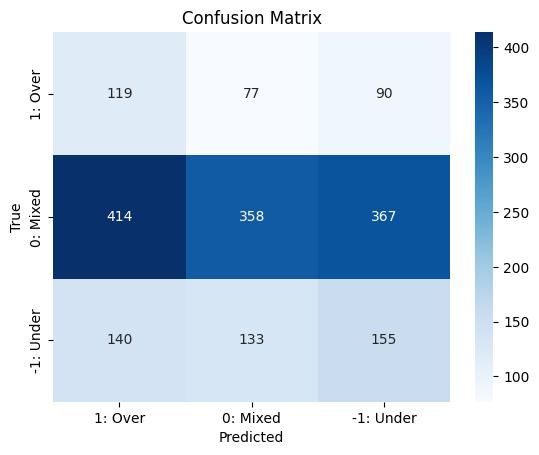

In [21]:
#Visualize Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1: Over', '0: Mixed', '-1: Under'],
            yticklabels=['1: Over', '0: Mixed', '-1: Under'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Confirms what we saw in our classification report. We suffer from a lot of false positives for class
#1 classification. True 0 classification (middle row) shows that we really do have horrible recall. 
#While the model is not accurate at all, it's still possible to make the generalization that it suffers
#the most from the mixed (0) class.

In [23]:
import numpy as np
#Examine Feature Importance


# Pull feature names after encoding
feature_names = X.columns

# Get coefficients from model
coefs = model.coef_

# For multinomial, one row per class
for i, class_label in enumerate(model.classes_):
    print(f"\nTop features for class {class_label}:")
    top_features = np.argsort(coefs[i])[::-1][:10]
    for idx in top_features:
        print(f"{feature_names[idx]:<30} {coefs[i][idx]:.4f}")


#Not much meaning in the top features for this model. We have low accuracy so these don't matter. 
#Time to move to more complex model.


Top features for class -1:
CS                             0.3347
FO                             0.3190
PO                             0.2343
num_pitch_types                0.1124
avg_pitch_speed                0.0469
SV                             0.0442
SL                             0.0410
CU                             0.0407
KC                             0.0007
FC                             -0.0125

Top features for class 0:
SV                             0.1429
SI                             0.1206
pitcher_throws_R               0.1173
FO                             0.1103
PO                             0.0091
CU                             0.0062
ST                             -0.0036
CS                             -0.0151
SL                             -0.0237
FF                             -0.0254

Top features for class 1:
FF                             0.2717
FS                             0.2601
CH                             0.2234
pitcher_throws_R               0.1744
F

In [47]:
#XGBoost Model - We want to handle high-cardinality features with label encoding, 
#have a built-in handling for class imbalance (dataset dominated by 0 class), while still balancing
#for accuracy/speed. 

#Step 1: Encode categorical variables
from sklearn.preprocessing import LabelEncoder

for col in ['starting_pitcher', 'pitcher_team_full', 'home_team_full','batter1', 'batter2', 'batter3','pitcher_throws']:
    le = LabelEncoder()
    df_trios_enriched[col + '_encoded'] = le.fit_transform(df_trios_enriched[col])

In [59]:
#Step 2: Drop Columns and set up train/test
drop_cols = [
    'batter1', 'batter2', 'batter3',
    'hrr1', 'hrr2', 'hrr3',
    'label_all_over_1_5', 'label_all_under_1_5',
    'label_trio_success', 'label_trio_direction',  # will re-add as target
    'game_id', 'team_name', 'team_id',
    'pitcher_team', 'home_team', 'away_team',
    'home_team_full', 'away_team_full', 'pitcher_team_full',
    'starting_pitcher', 'game_date',
    'bat1_order', 'bat2_order', 'bat3_order', 'pitcher_throws'
]

# Define features with batter and pitcher/team encodings
X = df_trios_enriched.drop(columns=drop_cols)
X['pitcher_encoded'] = df_trios_enriched['starting_pitcher_encoded']
X['pitcher_team_encoded'] = df_trios_enriched['pitcher_team_full_encoded']
X['stadium_encoded'] = df_trios_enriched['home_team_full_encoded']
X['batter1_encoded'] = df_trios_enriched['batter1_encoded']
X['batter2_encoded'] = df_trios_enriched['batter2_encoded']
X['batter3_encoded'] = df_trios_enriched['batter3_encoded']
X['pitcher_throws_encoded'] = df_trios_enriched['pitcher_throws_encoded']

y = df_trios_enriched['label_trio_direction']

#For the purpose of XGBoost modeling, y should be 0,1,2 instead of -1,0,1.

# Remap labels: -1 → 0, 0 → 1, 1 → 2
y = df_trios_enriched['label_trio_direction'].map({-1: 0, 0: 1, 1: 2})

In [61]:
X.head()

,avg_pitch_speed,CH,CS,CU,FC,FF,FO,FS,KC,PO,...,starting_pitcher_encoded,pitcher_team_full_encoded,home_team_full_encoded,batter1_encoded,batter2_encoded,batter3_encoded,pitcher_throws_encoded,pitcher_encoded,pitcher_team_encoded,stadium_encoded
0,87.767391,True,False,True,True,True,False,False,False,False,...,131,25,12,303,47,408,0,131,25,12
1,87.767391,True,False,True,True,True,False,False,False,False,...,131,25,12,47,408,307,0,131,25,12
2,87.767391,True,False,True,True,True,False,False,False,False,...,131,25,12,408,307,462,0,131,25,12
3,87.767391,True,False,True,True,True,False,False,False,False,...,131,25,12,307,462,169,0,131,25,12
4,87.767391,True,False,True,True,True,False,False,False,False,...,131,25,12,462,169,146,0,131,25,12


In [63]:
from sklearn.model_selection import train_test_split

#train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


model = XGBClassifier(
    objective='multi:softmax',   # or 'multi:softprob' if you want probabilities
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

C:\Users\justi\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:08:02] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0     0.6047    0.1822    0.2801       428
           1     0.6376    0.9377    0.7591      1139
           2     0.4694    0.0804    0.1373       286

    accuracy                         0.6309      1853
   macro avg     0.5706    0.4001    0.3921      1853
weighted avg     0.6040    0.6309    0.5525      1853



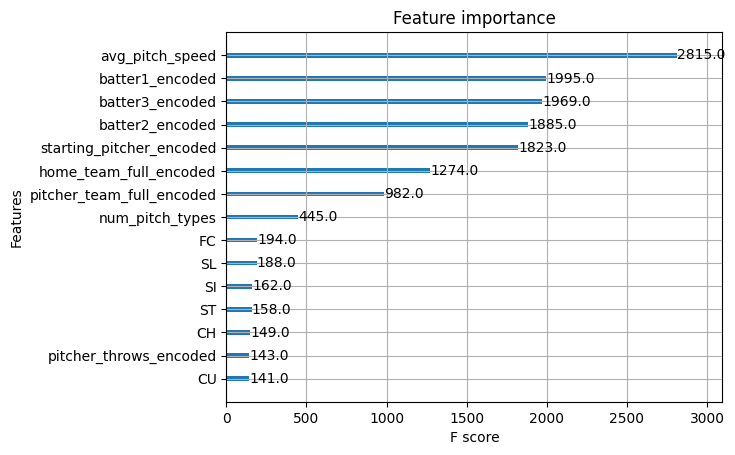

In [67]:
#Visualizing feature importances:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, max_num_features=15)
plt.show()

In [69]:
#avg_pitch_speed shows as most important overall feature. We should see if this remains the same
#with additional data. As expected, batter identity and pitcher identity are important in prediction.
#home team (stadium) and pitcher team (defenders) are clearly important, but to a lesser degree. Should
#still be included in future analyses. Later analyses can still include num pitch types (repertoire),
#but can exclude individual pitch types going forward. These clearly don't matter. 

In [75]:
import os
os.getcwd()

'C:\\Users\\justi'

In [77]:
os.listdir()

['.anaconda',
 '.conda',
 '.condarc',
 '.continuum',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 '.pybaseball',
 'anaconda3',
 'anaconda_projects',
 'ansel',
 'AppData',
 'Application Data',
 'combined_data.csv',
 'Contacts',
 'Cookies',
 'Desktop',
 'df_merged.csv',
 'df_trios_enriched.csv',
 'Documents',
 'Downloads',
 'Favorites',
 'Links',
 'Local Settings',
 'MLBACTUAL.ipynb',
 'mlb_project.ipynb',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{e8aeca20-e196-11ef-8060-d0fdcf170afc}.TM.blf',
 'NTUSER.DAT{e8aeca20-e196-11ef-8060-d0fdcf170afc}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{e8aeca20-e196-11ef-8060-d0fdcf170afc}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'OneDrive',
 'Pictures',
 'PrintHood',
 'Recent',
 'Saved Games',
 'Searches',
 'SendTo',
 'Start Menu',
 'Templates',
 'Untitled1.ipynb',
 'Videos']